# First model

This model is the simplest possible model we can think of. Inputs will be the list of points delimiting the bone and tooth area and their squares and cross-products to account for second order contributions.

The outputs will be the coordinates of optimal axe.

The cost function is the distance of the two points. 

## First step: load and prepare the datasets

Loads the datasets prepared by the `dataset_gen` notebook, then prepare the input by appending all the cross-products.

In [1]:
import pandas as pd

from second_util import MODEL_NAME, INPUT_DATASET, OUTPUT_DATASET
from utils import datadir

input_dataset = pd.read_pickle(datadir(INPUT_DATASET))
output_dataset = pd.read_pickle(datadir(OUTPUT_DATASET))

In [2]:
import numpy as np
from typing import Iterator
from itertools import permutations


def shuffle_points(s: np.ndarray) -> Iterator[np.ndarray]:
    for p1 in permutations(range(4)):
        for p2 in permutations(range(4, 8)):
            idxs = p1 + p2
            x = np.reshape(s, (-1, 2))
            x = x[idxs, :]
            x = np.reshape(x, -1)
            yield x


def prepare_input(orig: pd.DataFrame) -> Iterator[np.ndarray]:
    for row in orig.to_numpy():
        yield from shuffle_points(row)

In [3]:
prepared_input = np.array([r for r in prepare_input(input_dataset)])


In [4]:
prepared_input

array([[-6.95538769, -9.47220506, -1.20665715, ..., -1.29582557,
        -1.22064598,  4.0395157 ],
       [-6.95538769, -9.47220506, -1.20665715, ...,  4.0395157 ,
         7.03679935, -1.29582557],
       [-6.95538769, -9.47220506, -1.20665715, ...,  5.13603177,
        -1.22064598,  4.0395157 ],
       ...,
       [ 1.99868123, -0.86422219, -3.67963267, ...,  5.73834977,
         8.35886313,  7.96501758],
       [ 1.99868123, -0.86422219, -3.67963267, ...,  7.96501758,
        -0.18233334, 13.1943888 ],
       [ 1.99868123, -0.86422219, -3.67963267, ..., 13.1943888 ,
         8.35886313,  7.96501758]])

In [5]:
prepared_output = output_dataset[['Ox', 'Oy']].to_numpy()
cos = np.cos(output_dataset['alpha'].to_numpy()).reshape((-1, 1))
sin = np.sin(output_dataset['alpha'].to_numpy()).reshape((-1, 1))
display(cos.shape)
prepared_output = np.concatenate([prepared_output, cos, sin], axis=-1)
display(prepared_output.shape)
prepared_output = np.repeat(prepared_output,
                            repeats=prepared_input.shape[0] / prepared_output.shape[0], axis=0)
output_dim = prepared_output.shape[1]
display(prepared_output.shape)
display(output_dim)

(1000, 1)

(1000, 4)

(576000, 4)

4

In [6]:
prepared_output

array([[ 1.71811834, -0.46983955,  0.83992774,  0.54269825],
       [ 1.71811834, -0.46983955,  0.83992774,  0.54269825],
       [ 1.71811834, -0.46983955,  0.83992774,  0.54269825],
       ...,
       [-1.38602267,  1.63848183,  0.85284831,  0.52215874],
       [-1.38602267,  1.63848183,  0.85284831,  0.52215874],
       [-1.38602267,  1.63848183,  0.85284831,  0.52215874]])

In [7]:
import tensorflow as tf

prepared_input_ds = tf.data.Dataset.from_tensors(tf.convert_to_tensor(prepared_input))

2024-01-27 22:08:42.084179: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-01-27 22:08:42.084206: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-01-27 22:08:42.084212: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-01-27 22:08:42.084301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-27 22:08:42.084565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
input_dim = prepared_input_ds.get_single_element().shape[1]
input_dim

16

In [9]:
prepared_output_ds = tf.data.Dataset.from_tensors(tf.convert_to_tensor(input_dataset))
prepared_output

array([[ 1.71811834, -0.46983955,  0.83992774,  0.54269825],
       [ 1.71811834, -0.46983955,  0.83992774,  0.54269825],
       [ 1.71811834, -0.46983955,  0.83992774,  0.54269825],
       ...,
       [-1.38602267,  1.63848183,  0.85284831,  0.52215874],
       [-1.38602267,  1.63848183,  0.85284831,  0.52215874],
       [-1.38602267,  1.63848183,  0.85284831,  0.52215874]])

## Now prepare the network

First the later is a "convolution" layer that generates byproduct of initial set coordinates until a specified order.

Next there's a dense unit that tries to project the input vector into an higher dimensional space.

The output is feeded directly to the output stage and to a non linear stage that should extract any non linear feature.

The final stage will infer the output features from the higher dimensional space + the output from the non linear stages.

In [10]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from utils import CrossProductLayer


def setup_model_v2(order=3, with_squares=True, input_dim=input_dim, num_not_lin=3,
                   units=32, lin_depth=1, dropout=0.05,
                   non_lin_activation=tf.keras.layers.LeakyReLU) -> tf.keras.Model:
    input_layer = tf.keras.layers.Input(input_dim)

    # layers
    x = input_layer

    if (order > 1):
        cross = CrossProductLayer(order=order, with_squares=with_squares, )
        x = cross(x)

    dense1 = tf.keras.layers.Dense(units=units)

    x1 = dense1(x)

    drop = tf.keras.layers.Dropout(rate=dropout)

    x = drop(x1)

    concat1 = tf.keras.layers.Concatenate()
    x = concat1([x1, x])

    if num_not_lin:

        def not_lin(x):
            for i in range(lin_depth):
                densen = tf.keras.layers.Dense(units=max(units / (2 ** i), 8))
                norm = tf.keras.layers.BatchNormalization()
                actn = non_lin_activation()
                dout = tf.keras.layers.Dropout(rate=dropout)

                x = densen(x)
                x = norm(x)
                x = actn(x)
                x = dout(x)
            return x

        not_lins = [x] + [not_lin(x) for _ in range(num_not_lin)]

        concat = tf.keras.layers.Concatenate(axis=-1)

        x = concat(not_lins)

    densef = tf.keras.layers.Dense(units=4)
    x = densef(x)

    #drop2 = tf.keras.layers.Dropout(rate=dropout)
    #x = drop2(x)

    def norm_angle(i: tf.Tensor) -> tf.Tensor:
        c = tf.reshape(i[:, 2], (-1, 1))
        s = tf.reshape(i[:, 3], (-1, 1))
        n = tf.sqrt(c * c + s * s)
        r = tf.concat([i[:, 0:2], c / n, s / n], axis=-1)
        return r

    norm_layer = tf.keras.layers.Lambda(norm_angle)

    x = norm_layer(x)

    output_layer = x

    model = tf.keras.models.Model(input_layer, output_layer)

    return model


In [11]:
model = setup_model_v2(num_not_lin=1, units=1024, order=2, lin_depth=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 cross_product_layer (Cross  (None, 152)                  152       ['input_1[0][0]']             
 ProductLayer)                                                                                    
                                                                                                  
 dense (Dense)               (None, 1024)                 156672    ['cross_product_layer[0][0]'] 
                                                                                                  
 dropout (Dropout)           (None, 1024)                 0         ['dense[0][0]']           

#### Test the model before training

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.03728945, 0.0091206 , 0.01085252, 0.99994105]], dtype=float32)>

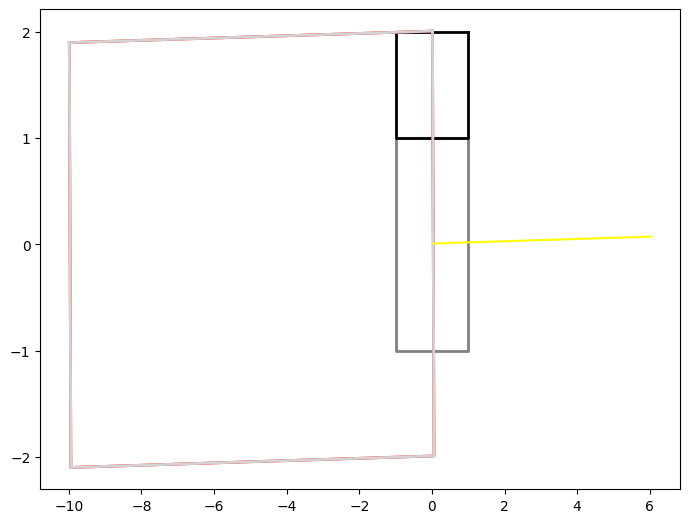

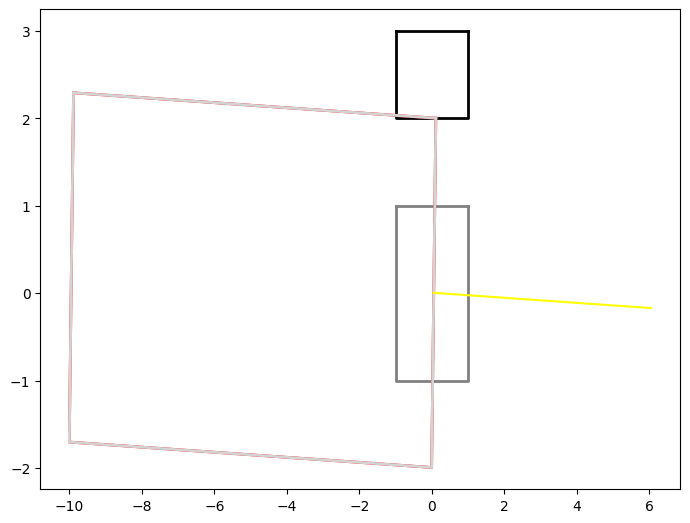

In [12]:

import numpy as np
from second_util import convert_sol

s1 = np.array([1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 2, -1, 2, -1, 1])
import matplotlib.pyplot as plt
from utils import draw_solution

fig = plt.figure()
ax = fig.add_axes((0, 0, 1, 1))

sol = model(tf.convert_to_tensor([s1]))

display(sol)
draw_solution(ax, s1.reshape(2, 8), convert_sol(sol))

s1 = np.array([1, 1, -1, 1, -1, -1, 1, -1, 1, 2, 1, 3, -1, 3, -1, 2])
fig = plt.figure()
ax = fig.add_axes((0, 0, 1, 1))
sol = model(tf.convert_to_tensor([s1]))
draw_solution(ax, s1.reshape(2, 8), convert_sol(sol))


### Do the training



In [13]:

import math

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.01,
                                                                     decay_steps=400,
                                                                     decay_rate=0.001)),
    loss=tf.keras.losses.MeanSquaredError(name="train_loss")
)

BATCH_SIZE = 10240


def split_input(inpts: np.ndarray, outs: np.ndarray, shuffle=True):
    indexes = np.arange(inpts.shape[0])
    if shuffle:
        np.random.shuffle(indexes)
    train_size = math.ceil(inpts.shape[0] * 9 / 10)
    train_indexes = indexes[0:train_size]
    test_indexes = indexes[train_size:-1]
    return (inpts[train_indexes], outs[train_indexes]), (inpts[test_indexes], outs[test_indexes])


(train_x, train_y), (test_x, test_y) = split_input(prepared_input,
                                                   prepared_output)
display(train_x.shape)
display(train_y.shape)


(518400, 16)

(518400, 4)

In [14]:

res = model.fit(x=train_x, y=train_y, batch_size=BATCH_SIZE, epochs=20,
                validation_data=(test_x, test_y))

Epoch 1/20


2024-01-27 22:09:02.258677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 10s 159ms/step - loss: 2.4702 - val_loss: 0.5723
Epoch 2/20
51/51 [==============================] - 5s 89ms/step - loss: 0.0883 - val_loss: 0.1065
Epoch 3/20
51/51 [==============================] - 4s 86ms/step - loss: 0.0641 - val_loss: 0.0564
Epoch 4/20
51/51 [==============================] - 4s 85ms/step - loss: 0.0512 - val_loss: 0.0382
Epoch 5/20
51/51 [==============================] - 4s 85ms/step - loss: 0.0413 - val_loss: 0.0399
Epoch 6/20
51/51 [==============================] - 4s 83ms/step - loss: 0.0363 - val_loss: 0.0493
Epoch 7/20
51/51 [==============================] - 4s 83ms/step - loss: 0.0340 - val_loss: 0.0352
Epoch 8/20
51/51 [==============================] - 4s 84ms/step - loss: 0.0314 - val_loss: 0.0410
Epoch 9/20
51/51 [==============================] - 4s 82ms/step - loss: 0.0276 - val_loss: 0.0267
Epoch 10/20
51/51 [==============================] - 4s 83ms/step - loss: 0.0246 - val_loss: 0.0325
Epoch 11/20
51/51 

## Plot stats

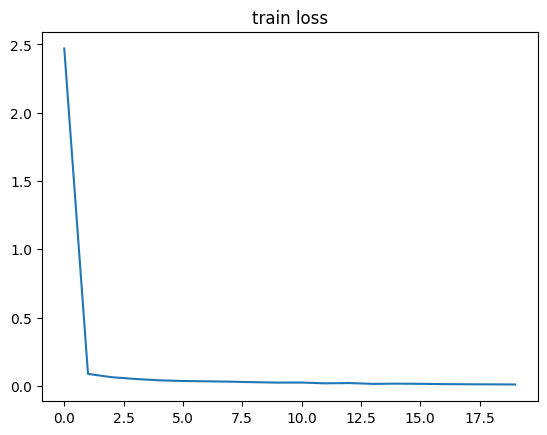

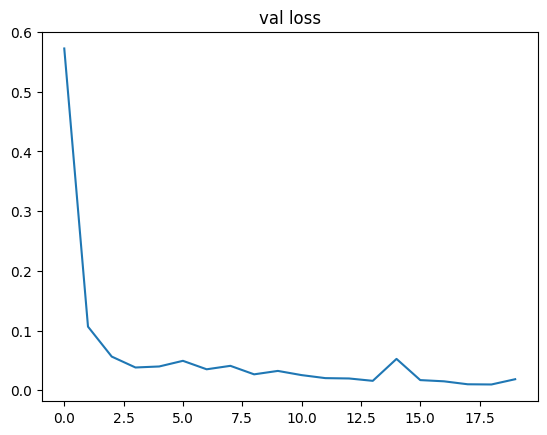

In [15]:
%matplotlib inline


plt.title("train loss")
plt.plot(res.history['loss'])
plt.show()
plt.title("val loss")
plt.plot(res.history['val_loss'])
plt.show()

#### Some random tests

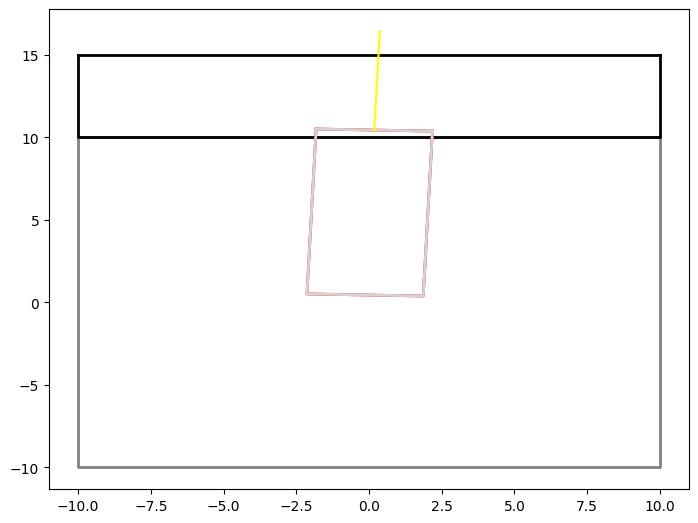

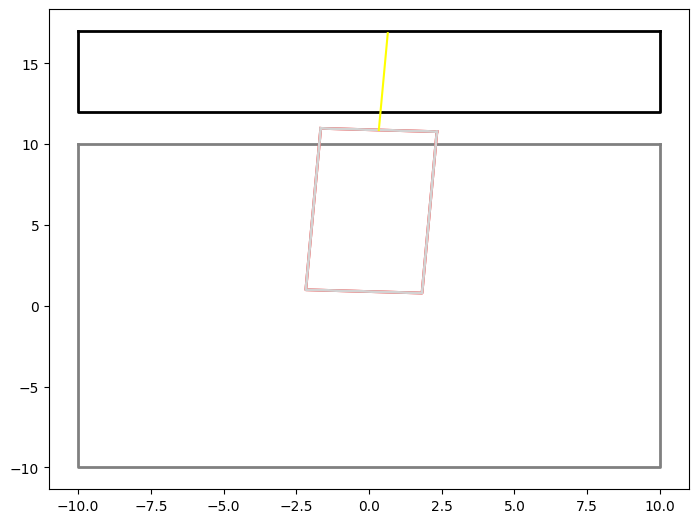

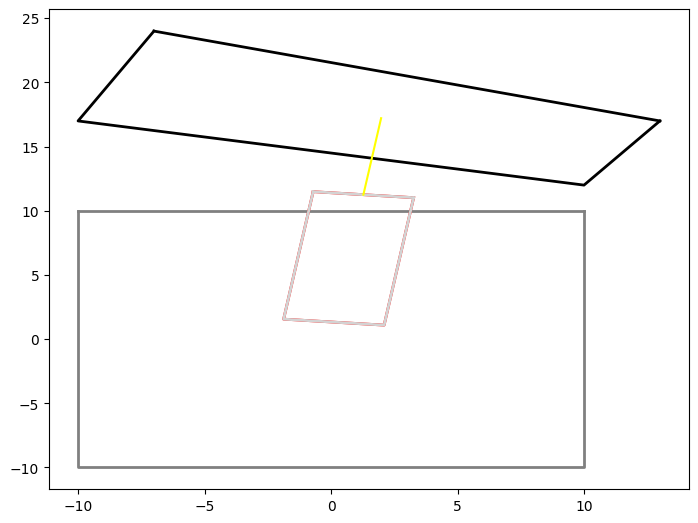

In [16]:
from typing import Callable

s1 = np.array([-10, -10, 10, -10, 10, 10, -10, 10, -10, 10, 10, 10, 10, 15, -10, 15])


def draw_one(model=model) -> Callable[[plt.Axes, np.ndarray], None]:
    def _draw_one(ax, sample):
        sol = model(tf.convert_to_tensor([sample]))
        draw_solution(ax, sample.reshape(2, -1), convert_sol(sol))

    return _draw_one


draw_sample = draw_one(model)

fig = plt.figure()
ax = fig.add_axes((0, 0, 1, 1))
draw_sample(ax, s1)
plt.show()

s1 = np.array([-10, -10, 10, -10, 10, 10, -10, 10, -10, 12, 10, 12, 10, 17, -10, 17])
fig = plt.figure()
ax = fig.add_axes((0, 0, 1, 1))
draw_sample(ax, s1)
plt.show()

s1 = np.array([-10, -10, 10, -10, 10, 10, -10, 10, -10, 17, 10, 12, 13, 17, -7, 24])
fig = plt.figure()
ax = fig.add_axes((0, 0, 1, 1))
draw_sample(ax, s1)
plt.show()


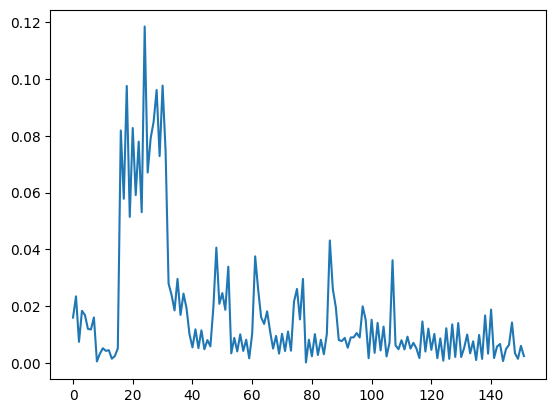

In [17]:
plt.plot(np.abs(model.weights[0].numpy()))

In [18]:
model.save(datadir(MODEL_NAME))

INFO:tensorflow:Assets written to: /Users/vittorio/Projects/Implantmaster.ai/prototype1/data/model_implant/assets


INFO:tensorflow:Assets written to: /Users/vittorio/Projects/Implantmaster.ai/prototype1/data/model_implant/assets
